In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn.cluster import KMeans
files_path = './data/'

In [2]:
# get all probabilities with foul
def make_players_prob_df(df):
    # filtrado para tener solo linea defensiva
    df = df[df.pff_role == 'Pass Block']
    # get all player's id
    #players = df.nflId.tolist()
    players = pd.unique(df.nflId)
    p_df = pd.DataFrame(columns=['nflId','pff_beatenByDefender_P','pff_hitAllowed_P','pff_hurryAllowed_P','pff_sackAllowed_P','foul1','foul2','foul3'])
    for player in players:
        aux = df[df.nflId == player]
        aux = aux.drop_duplicates(subset=['playId'])
        aux = aux[['pff_beatenByDefender','pff_hitAllowed','pff_hurryAllowed','pff_sackAllowed','foul1','foul2','foul3']]
        p_aux = pd.DataFrame({'nflId':player,
                             'pff_beatenByDefender_P':aux.pff_beatenByDefender.sum()/aux.shape[0],
                             'pff_hitAllowed_P':aux.pff_hitAllowed.sum()/aux.shape[0],
                             'pff_hurryAllowed_P':aux.pff_hurryAllowed.sum()/aux.shape[0],
                             'pff_sackAllowed_P':aux.pff_sackAllowed.sum()/aux.shape[0],
                             'foul1':aux.foul1.sum()/aux.shape[0],
                             'foul2':aux.foul2.sum()/aux.shape[0],
                             'foul3':aux.foul3.sum()/aux.shape[0]
                              },index=[0])
        p_df = pd.concat([p_df,p_aux])
    return p_df

In [3]:
# function to get final value
def get_metric_value(df,sf):
    '''inputs: 
        df -> dataframe with 'pff_beatenByDefender_P','pff_hitAllowed_P','pff_hurryAllowed_P','pff_sackAllowed_P','foul1','foul2','foul3' columns
        sf -> scale factor value
    '''
    aux = make_players_prob_df(df)
    aux['p_sum'] = aux[['pff_beatenByDefender_P','pff_hitAllowed_P','pff_hurryAllowed_P','pff_sackAllowed_P','foul1','foul2','foul3']].sum(axis=1)
    aux['p_sum_scaled'] = aux['p_sum']*sf
    return aux

In [5]:
def set_level(olpf):
    if olpf <= max_psum and olpf >=end_medium:
        level = 'HIGH'
    elif olpf <= end_medium and olpf >=start_medium:
        level = 'MEDIUM'
    elif olpf <= start_medium and olpf >=min_psum:
        level = 'LOW'
    return level

In [123]:
#os.listdir(files_path)
df_all = pd.read_csv(files_path+'pffScoutingData.csv')
df_p = pd.read_csv(files_path+'plays.csv')
player_df = pd.read_csv(files_path+'players.csv')

# Big Data Bowl 2023

## Offensive Line Player Efficiency


How we know if a player in offensive line is as good as we need?
We can evaluate a player if has a good performance if player can stop defense most of the time. With this, we know that the player will miss some occasions but, how many misses are enough?
How do we know if a player has an acceptable, poor or outstanding performance?  
  
With Offensive Line Player Efficiency (OLPE) we can know performance of every offensive player in the line.  

Offensive Line Player Efficiency (OLPE) is a metric that evaluates perfomance of offensive line players in a game or even in a season. Taking all plays in a game and evaluating if play performed well or poorly based on some variables that all players in the line has.  



# Variables Used
 To calculate OLPE we will use all data containing infromation about each fail play of every player. 
 To know if play count as fail to player we will take every time player allowed a sack, hit or hurry.  
   
 Also we will take if player where beaten by defender or if player made a foul, although it means the play did not ended as sack, hurry or hit, it means that offensive line player failed to achieve the goal of his position.
 Added to  
 
 All data used takes only **two values**, **1** if is true, **0** if is false.  
  
<font size="4">**HTA - Hit Allowed**</font>
   * Indicator for whether they are responsible for a hit on the QB
 

<font size="4">**HYA - Hurry Allowed**</font>


   * Indicator for whether they are responsible for a hurry on the QB
  
<font size="4">**SKA - Sack Allowed** </font>

   * Indicator for whether they are responsible for a sack on the QB
 

<font size="4"> **F1 - Foul1** </font>

   * If player commited first foul during the play
 
  
<font size="4"> **F2 - Foul2** </font>

   * If player commited secod foul during the play
 
   
<font size="4"> **F3 - Foul3**</font>

   * If player commited thirt foul during the play
     


In [124]:
# adding foul name and nflid
for i in range(1,4):
    foul_name = 'foulName'+str(i)
    foul_nflid =  'foulNFLId'+str(i)
    poss_team = 'possessionTeam'+str(i)
    #aux_p = df_p[['playId',foul_name,foul_nflid]]  
    aux_p = df_p[['playId','possessionTeam',foul_name,foul_nflid]]  
    aux_p = aux_p.rename(columns={'possessionTeam':poss_team})
    aux_p = aux_p[aux_p.playId.isin(df_all.playId.tolist())]
    df_all = df_all.merge(aux_p,how='left',left_on=['playId','nflId'],right_on=['playId',foul_nflid])

In [125]:
df_all['foulName1'] = df_all['foulName1'].fillna('')
df_all['foulName2'] = df_all['foulName2'].fillna('')
df_all['foulName3'] = df_all['foulName3'].fillna('')
df_all['foul1'] = df_all.apply(lambda x: 0 if x['foulName1']=='' else 1, axis=1)
df_all['foul2'] = df_all.apply(lambda x: 0 if x['foulName2']=='' else 1, axis=1)
df_all['foul3'] = df_all.apply(lambda x: 0 if x['foulName3']=='' else 1, axis=1)

## Target variable

we will use probability of failed play for a player considering all described variables. 


## Criteria:
   * Scale factor must consider at least 95% of probability of faliure of all players  
   * Player must have at least 10 registered plays  
   * All plays must be unique for each player  
   * All data must be from offensive fully blocking a defender
 

In [126]:
# selecting data that complies with the conditions of use
df_all = df_all.drop_duplicates(subset=['nflId','playId'],keep='last')
df_aux = df_all.nflId.value_counts().rename_axis('nflId').reset_index(name='counts')
df_aux = df_aux[df_aux.counts > 30]

df_all = df_all[df_all.nflId.isin(df_aux.nflId.tolist())]
df_all = df_all[df_all.pff_role == 'Pass Block']

## Model

A simple model was generated using all plays where target player was to get the probability of miss in every variable.
Since all variables are mutually exclusive events, ofensive line player failure metric ***OLPF***  is the sum of all probabilities as is shown in the formula below.

$$OLPF = \left ( P(HTA) + P(HYA) + P(SKA) + P(F1) + P(F2) + P(F3) \right ) \ast \beta $$

In terms of total plays and their results, the formula can be expressed as below  

$$OLPF = \left ( \frac{HTA}{TP} + \frac{HYA}{TP} + \frac{SKA}{TP} + \frac{F1}{TP} + \frac{F2}{TP} + \frac{F3}{TP} \right )\ast \beta $$

where $\beta$ is a scale factor

In [127]:
df = df_all
pro_df = make_players_prob_df(df)
pro_df['p_sum'] = pro_df[['pff_beatenByDefender_P','pff_hitAllowed_P','pff_hurryAllowed_P','pff_sackAllowed_P','foul1','foul2','foul3']].sum(axis=1)

## Selecting Scale Factor  

Scale factor will be used to show the metric in a range between 0 to 10  
  
  
We will get the value of scale factor with a simple formula  
  
$$\beta = \frac{1}{q} * 100$$  

where ***q***  is maximum value until selected percentage of data


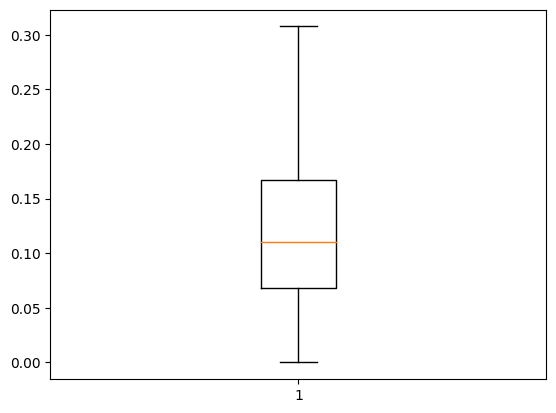

In [128]:
# Deleting outliers to get scale factor value
bp = plt.boxplot(pro_df['p_sum'],showfliers=False)
maxx = bp['caps'][1].get_ydata()[0]
pro_df= pro_df[pro_df['p_sum'] <= maxx]

In [129]:
# Getting scale factor
q = 1 # quantile
s_f = (1/pro_df.quantile(q=q).p_sum) * 100
print("Sclae factor value: ",s_f)

Sclae factor value:  325.0


/tmp/ipykernel_6364/1980769470.py:3: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  s_f = (1/pro_df.quantile(q=q).p_sum) * 100


## Model results

The result of probability of failure of all players are shown below

In [130]:
#pro_df['p_sum'] = pro_df['p_sum'] * s_f
pro_df[['pff_beatenByDefender_P', 'pff_hitAllowed_P',
       'pff_hurryAllowed_P', 'pff_sackAllowed_P', 'foul1', 'foul2', 'foul3',
       'p_sum']] = pro_df[['pff_beatenByDefender_P', 'pff_hitAllowed_P',
       'pff_hurryAllowed_P', 'pff_sackAllowed_P', 'foul1', 'foul2', 'foul3',
       'p_sum'] ]* s_f

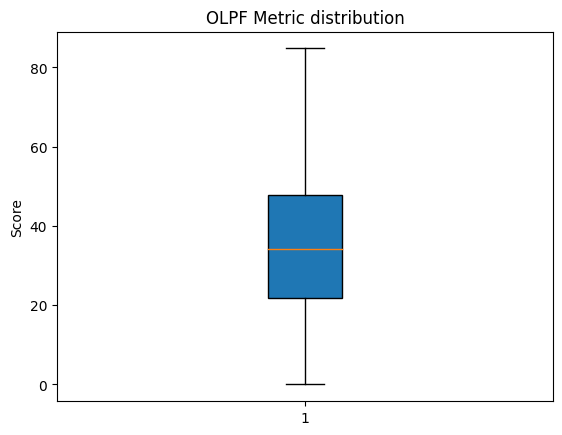

In [131]:
bp = plt.boxplot(pro_df['p_sum'],showfliers=False,patch_artist=True)
plt.title('OLPF Metric distribution')
plt.ylabel('Score')
median = bp['medians'][0].get_ydata()
max_psum = bp['caps'][1].get_ydata()[0]
min_psum = bp['caps'][0].get_ydata()[0]
end_medium = bp['whiskers'][1].get_ydata()[0]
start_medium = bp['whiskers'][0].get_ydata()[0]

In this case that we are measuring a metric of player failures, we can use a box plot to take advantage of the ranges shown and use them as indicators as described below.

**Levels of OLPF**  

**Low**
   * When OLPF is in the range of Lowest general Score to Q1, this means the performance was outstanding
  
**Medium**
   * When OLPF is in the range of Q1 to Q3, this means the performance was good 
 
**High**

   * When OLPF is in the range of Q3 to maxumin general score, this means the performace was poor

## Verifying the number of levels

We use the three different areas of the boxplot to create the OLPF levels based on the common use of 3 levels to measure a metric (low, medium and high).
But for this case, we must have the levels based on the same information that the data gives us.
For that, we will use the elbow technique with kmeans to know the number of clusters (levels) we need for the metric.

/home/oscar/Documentos/Python/NFL/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/oscar/Documentos/Python/NFL/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/oscar/Documentos/Python/NFL/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/oscar/Documentos/Python/NFL/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly t

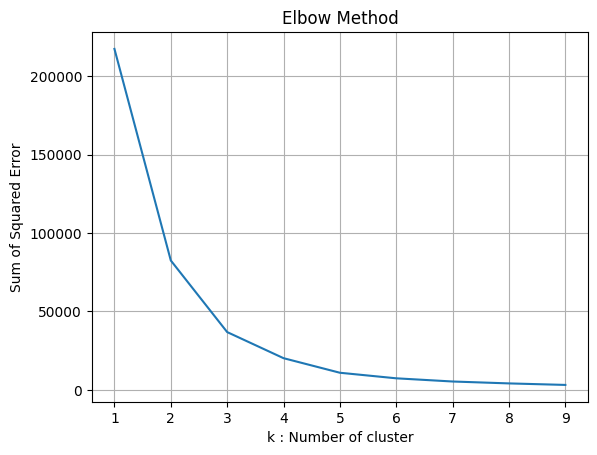

In [132]:
sse = {}
sil = []
kmax = 10
fig = plt.subplots(nrows = 1, ncols = 1)
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(pro_df['p_sum'].to_numpy().reshape(-1,1))
    sse[k] = kmeans.inertia_ 
plt.plot(list(sse.keys()),list(sse.values()));
plt.title('Elbow Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Sum of Squared Error")
plt.grid()
plt.show()

The graph above show that the sum of squared error changes drastically until have 3 clusters, from there the change is much less, so we can say that the optimun number of clusters is three  

Now, let's see where is the position of the clusters

In [133]:
modelo_kmeans = KMeans(n_clusters=3, n_init=25, random_state=123)
modelo_kmeans.fit(pro_df['p_sum'].to_numpy().reshape(-1,1))
#modelo_kmeans.cluster_centers_

KMeans(n_clusters=3, n_init=25, random_state=123)

Text(0, 0.5, 'Score')

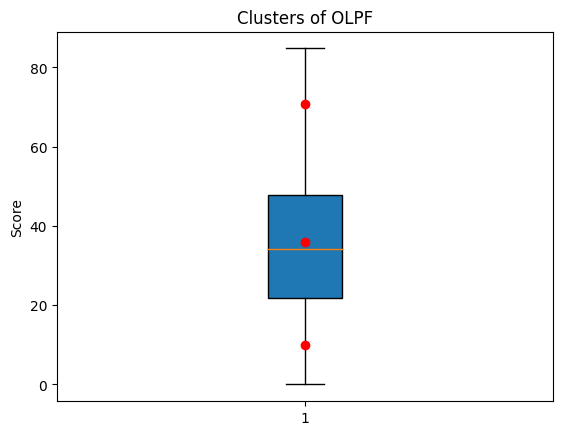

In [134]:
plt.boxplot(pro_df['p_sum'].to_numpy().reshape(-1,1),showfliers=False,patch_artist=True)
plt.plot(np.ones(3),modelo_kmeans.cluster_centers_,'ro')
plt.title('Clusters of OLPF')
plt.ylabel('Score')

## Using the model

### Rating player performance

In this case of use we will check the performance in a week and in 8 weeks

#### Performance in week 1

In [135]:
# Rating player performance first week
df_w = pd.read_csv(files_path+'week1.csv')

In [136]:
# target player
player_df[player_df.nflId == 53471]

,nflId,height,weight,birthDate,collegeName,officialPosition,displayName
1507,53471,6-6,308,NaN,NaN,T,Liam Eichenberg


In [137]:
# getting all playId from week1 with nflId
w1_plays = pd.unique(df_w[df_w.nflId == 53471]['playId']).tolist()
# extract pffScoutingData with all playIds 
week1 = df_all[(df_all.playId.isin(w1_plays)) & (df_all.nflId == 53471 )]

In [138]:
p_sum = get_metric_value(week1,s_f)['p_sum_scaled'][0]
p_sum = [p_sum]
p_sum

[68.42105263157895]

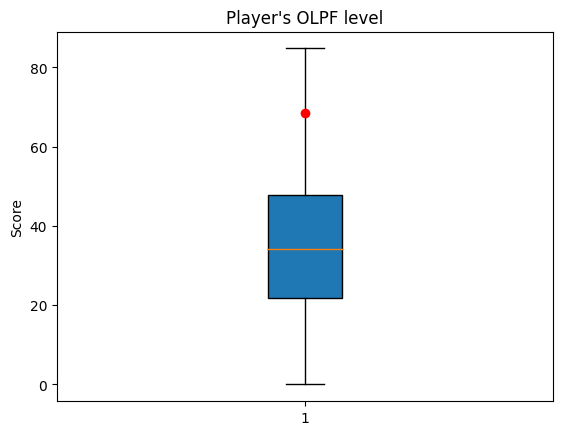

In [139]:
plt.boxplot(pro_df['p_sum'].to_numpy().reshape(-1,1),showfliers=False,patch_artist=True)
plt.plot(np.ones(len(p_sum)),p_sum,'ro')
plt.title("Player's OLPF level")
plt.ylabel('Score')
plt.show()

**How to read**  

As we can see, metric of target player is in high section, this means that player had a bad performance in target week  

To this metric, we want score as low as possible to be a outstanding player, but if the OLPF falls into medium level (and it will be like this most of the time) it's also good

#### Performance in 8 weeks

In [140]:
weeks_df_list = list()
nflid = 53471
for i in range(1,9):
    df = pd.read_csv(files_path+'week'+str(i)+'.csv')
    df = df[df.nflId == nflid]
    # getting all playId from week1 with nflId
    w_plays = pd.unique(df[df.nflId == nflid]['playId']).tolist()
    # extract pffScoutingData with all playIds 
    week = df_all[(df_all.playId.isin(w_plays)) & (df_all.nflId == nflid )]
    df = get_metric_value(week,s_f)['p_sum_scaled'].to_frame()
    df['week'] = i
    weeks_df_list.append(df)
    if i == 8:
        df = pd.concat(weeks_df_list)
        
        

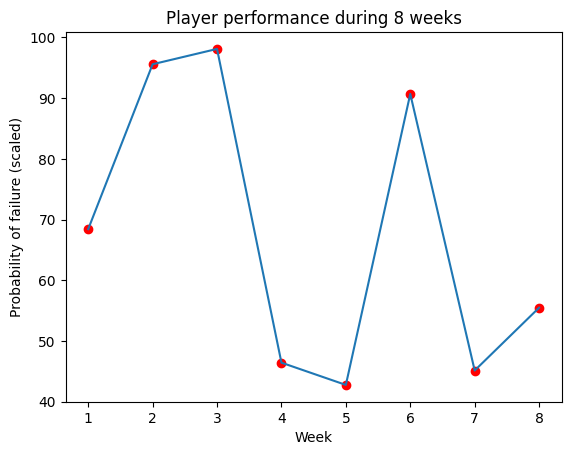

In [141]:
plt.plot(df.week,df.p_sum_scaled,'ro')
plt.plot(df.week,df.p_sum_scaled)
plt.title(r'Player performance during 8 weeks')
plt.xlabel('Week')
plt.ylabel('Probability of failure (scaled)')
plt.show()

Player's P(f) (as we can expect) in some cases is better than otherones but in most cases is high score, let's see mean 

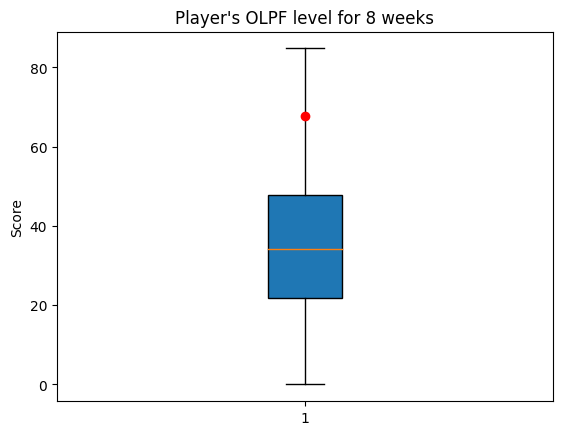

In [142]:
player_mean = df.describe().iloc[1]['p_sum_scaled']
#y0 = [np.interp(player_mean,x * s_f,density(x))]
x0 = [player_mean]

plt.boxplot(pro_df['p_sum'].to_numpy().reshape(-1,1),showfliers=False,patch_artist=True)
plt.plot(np.ones(len(x0)),x0,'ro')
plt.title("Player's OLPF level for 8 weeks")
plt.ylabel('Score')
plt.show()

As we can see, the mean of the 8 weeks is **67.8** and this is over the 75% OLPF. With this now we know player needs to improve his performance during plays

### Team players ranking

In [143]:
test_df = pro_df.copy()

In [144]:
# getting team per nflId
for j in range(1,9):
    if j==1:
        df_w = pd.read_csv(files_path+'week'+str(j)+'.csv')
        pass
    else:
        df_aux = pd.read_csv(files_path+'week'+str(j)+'.csv')
    df_w = pd.concat([df_w,df_aux])

In [145]:
df_w = df_w.drop_duplicates(subset=['nflId'],keep='last')
df_w = df_w[['nflId','team']]
team_p = test_df.merge(df_w,on='nflId')
team_p = team_p[~team_p.team.isna()]
player_df = player_df[['nflId','displayName']]
team_p = team_p.merge(player_df,on='nflId')

In [146]:
mia_df = team_p[team_p.team == 'MIA'].sort_values(by='p_sum',ascending=False)[['displayName','p_sum']]
mia_df = mia_df.rename(columns={'p_sum':'OLPF'})
mia_df

,displayName,OLPF
205,Myles Gaskin,79.054054
202,Liam Eichenberg,67.805755
198,Jesse Davis,65.909091
302,Austin Jackson,58.362676
201,Solomon Kindley,48.750000
301,Durham Smythe,39.000000
345,Adam Shaheen,32.500000
200,Robert Hunt,31.105611
392,Austin Reiter,29.545455
199,Michael Deiter,22.608696


In [147]:
mia_df['level'] = ''

In [148]:
mia_df['level'] = mia_df.OLPF.map(lambda x: set_level(x))

In [149]:
mia_pie = mia_df.groupby('level').count()[['displayName']]

Text(0.5, 1.0, "Miami player's levels ")

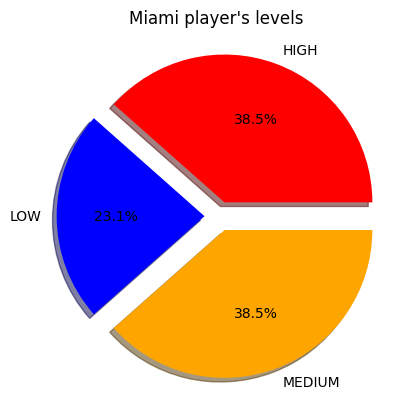

In [150]:
explode = (0.1, 0.1, 0.1)
colors = ['red','blue','orange']
plt.pie(mia_pie['displayName'].tolist(), explode=explode,labels=mia_pie.index, autopct='%1.1f%%',
        shadow=True,colors=colors)
plt.title("Miami player's levels ")

# ###############

In [33]:
density = stats.gaussian_kde(pro_df['p_sum'])

In [34]:
a = pro_df['p_sum'].tolist()
bins = np.linspace(0, 1, 400)
n, x = np.histogram(np.array(a), bins,density=True)

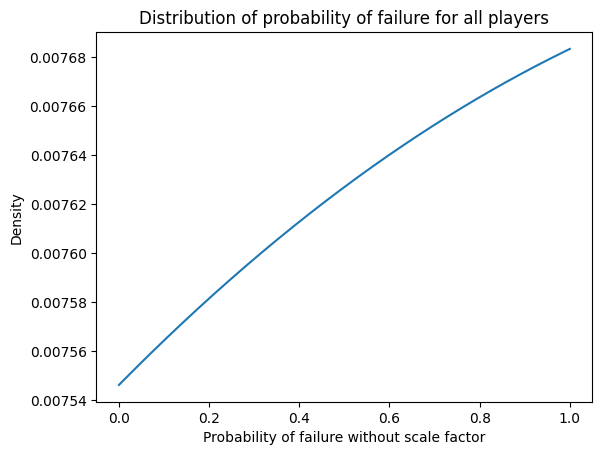

In [35]:
plt.title('Distribution of probability of failure for all players')
plt.xlabel('Probability of failure without scale factor')
plt.ylabel('Density')
plt.plot(x, density(x))
#plt.fill(x, density(x))
plt.show()

In [36]:
pro_df.describe()

,pff_beatenByDefender_P,pff_hitAllowed_P,pff_hurryAllowed_P,pff_sackAllowed_P,foul1,foul2,foul3,p_sum
count,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.0,401.000000
mean,13.109288,4.189988,14.681187,3.410118,1.098149,0.059103,0.0,36.547833
std,12.823350,7.296916,14.022102,7.068049,2.895803,0.789679,0.0,23.313014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,0.000000,0.000000,5.416667,0.000000,0.000000,0.000000,0.0,21.875000
50%,11.798680,1.354167,12.500000,0.000000,0.000000,0.000000,0.0,34.210526
75%,19.243421,5.416667,20.312500,3.367876,1.305221,0.000000,0.0,47.879464
max,76.470588,54.166667,90.277778,65.000000,29.545455,15.476190,0.0,100.000000


Show only our area of interest, in this case we will use the 98% of all data

/tmp/ipykernel_6364/2728554946.py:7: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.axis([0, pro_df.quantile(q=q).p_sum * s_f, 0, 10])


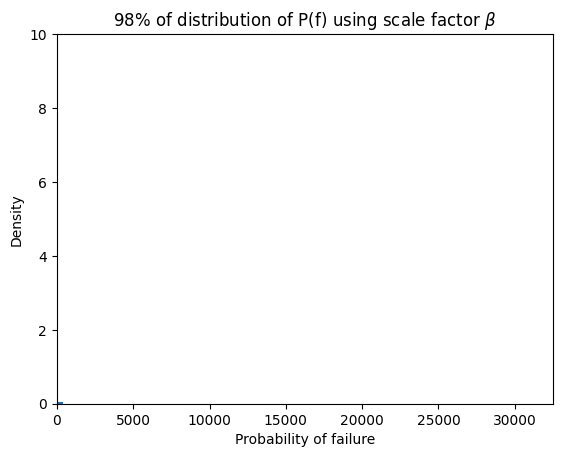

In [37]:
plt.title(r'98% of distribution of P(f) using scale factor $\beta$')
plt.xlabel('Probability of failure')
plt.ylabel('Density')
#plt.ylabel('Number of players $x10^{3}$')
plt.plot(x * s_f, density(x))
#plt.fill(x, density(x))
plt.axis([0, pro_df.quantile(q=q).p_sum * s_f, 0, 10])
plt.show()

/tmp/ipykernel_6364/1212126830.py:10: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.axis([0, pro_df.quantile(q=q).p_sum * s_f, 0, 10])


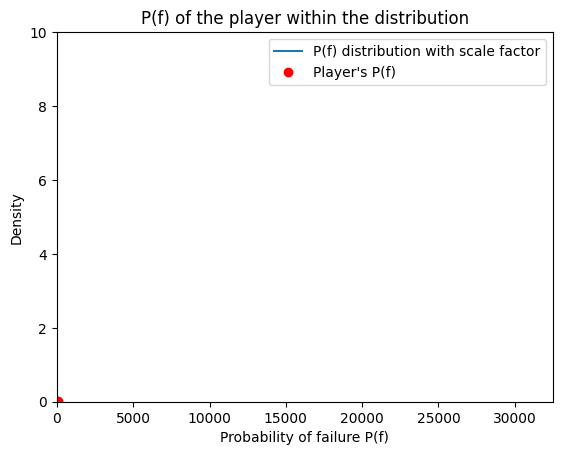

In [38]:
p_sum = get_metric_value(week1,s_f)['p_sum_scaled'][0]
y0 = [np.interp(p_sum,x * s_f,density(x))]
x0 = [p_sum]
plt.title('P(f) of the player within the distribution')
plt.xlabel('Probability of failure P(f)')
plt.ylabel('Density')
plt.plot(x * s_f, density(x))
plt.plot(x0,y0,'ro')
plt.legend(['P(f) distribution with scale factor',"Player's P(f)"])
plt.axis([0, pro_df.quantile(q=q).p_sum * s_f, 0, 10])
plt.show()

We can see that player is over top 75% (top 75 is 0.33) players with most failures in plays in this week.

### Team ranking

We will use the model to assign a score to all the teams using the failure probability of all their players and thus create a ranking where the first on the list will be the team with the most failures by their players.

In [39]:
# Getting players in the 98%
test_df = pro_df[pro_df.p_sum < pro_df.quantile(q=q).p_sum]

/tmp/ipykernel_6364/4257440253.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  test_df = pro_df[pro_df.p_sum < pro_df.quantile(q=q).p_sum]


In [40]:
# getting team per nflId
for j in range(1,9):
    if j==1:
        df_w = pd.read_csv(files_path+'week'+str(j)+'.csv')
        pass
    else:
        df_aux = pd.read_csv(files_path+'week'+str(j)+'.csv')
    df_w = pd.concat([df_w,df_aux])

In [41]:
df_w = df_w.drop_duplicates(subset=['nflId'],keep='last')
df_w = df_w[['nflId','team']]
team_p = test_df.merge(df_w,on='nflId')
team_p = team_p[~team_p.team.isna()]

In [42]:
pf_rank = team_p.groupby(by = 'team')['p_sum'].sum().sort_values(ascending = False).to_frame()

In [43]:
## making rank by probability of failure by team
#pf_rank = pf_rank.reset_index()
#pf_rank = pf_rank.sort_index(ascending=False).assign(p_failure_rank=range(1,len(pf_rank)+1))
#pf_rank =pf_rank.reset_index()
#pf_rank = pf_rank.drop(columns=['index'])
# ordenandolo de manera descendente, el mayor tiene mas fallos
pf_rank = pf_rank.reset_index()
pf_rank = pf_rank.assign(p_failure_rank=range(1,len(pf_rank)+1))

In [44]:
pf_rank

,team,p_sum,p_failure_rank
0,NE,688.498329,1
1,CAR,618.693857,2
2,IND,565.495228,3
3,NYJ,562.805740,4
4,BUF,541.757496,5
5,HOU,538.077481,6
6,LAC,531.110074,7
7,SEA,523.463322,8
8,CLE,508.930800,9
9,MIA,501.982085,10


### Improving the team's position in the ranking

Now we will use the model to see players with higher probability of failure of team in 1th position and team in the last position to change players of the first team for players of the seciond team and see how much does the score of the team with higher P(f) improve?

In [45]:
team_p['p_sum'] = team_p['p_sum']*s_f

In [46]:
team_p[team_p.team == 'CAR'].groupby(by='nflId').sum().sort_values(by='p_sum',ascending=False)

/tmp/ipykernel_6364/3748763817.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  team_p[team_p.team == 'CAR'].groupby(by='nflId').sum().sort_values(by='p_sum',ascending=False)


,pff_beatenByDefender_P,pff_hitAllowed_P,pff_hurryAllowed_P,pff_sackAllowed_P,foul1,foul2,foul3,p_sum
nflId,,,,,,,,
53499,36.111111,8.024691,32.098765,8.024691,0.000000,0.0,0.0,27384.259259
44882,31.707317,23.780488,15.853659,0.000000,0.000000,0.0,0.0,23185.975610
46755,22.674419,7.558140,30.232558,0.000000,0.000000,0.0,0.0,19651.162791
42362,19.835681,4.577465,24.413146,1.525822,4.577465,0.0,0.0,17852.112676
46170,34.210526,0.000000,8.552632,0.000000,0.000000,0.0,0.0,13898.026316
42424,10.435780,0.000000,23.853211,4.472477,2.981651,0.0,0.0,13566.513761
47995,20.428571,5.571429,9.285714,3.714286,1.857143,0.0,0.0,13278.571429
46140,0.000000,0.000000,20.312500,20.312500,0.000000,0.0,0.0,13203.125000
44876,16.927083,2.256944,18.055556,0.000000,1.128472,0.0,0.0,12469.618056


In [47]:
# listiong players with higger p(f)
player_df[player_df.nflId.isin([52859,42397,53499,45594,44882])]

,nflId,displayName
325,42397,Ameer Abdullah
634,44882,Pat Elflein
748,45594,Colin Thompson
1430,52859,Rodney Smith
1529,53499,Brady Christensen


In [48]:
# creating a df only for a team with biggest p_sum
t_team_df = team_p[team_p.team == 'CAR']

In [49]:
t_team_df

,nflId,pff_beatenByDefender_P,pff_hitAllowed_P,pff_hurryAllowed_P,pff_sackAllowed_P,foul1,foul2,foul3,p_sum,team
54,41436,4.513889,0.000000,12.413194,2.256944,0.000000,0.0,0.0,6234.809028,CAR
55,42362,19.835681,4.577465,24.413146,1.525822,4.577465,0.0,0.0,17852.112676,CAR
56,44876,16.927083,2.256944,18.055556,0.000000,1.128472,0.0,0.0,12469.618056,CAR
57,44882,31.707317,23.780488,15.853659,0.000000,0.000000,0.0,0.0,23185.975610,CAR
58,47995,20.428571,5.571429,9.285714,3.714286,1.857143,0.0,0.0,13278.571429,CAR
61,44820,25.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,8125.000000,CAR
62,46170,34.210526,0.000000,8.552632,0.000000,0.000000,0.0,0.0,13898.026316,CAR
63,53512,0.000000,0.000000,0.000000,27.083333,0.000000,0.0,0.0,8802.083333,CAR
66,46755,22.674419,7.558140,30.232558,0.000000,0.000000,0.0,0.0,19651.162791,CAR
286,42424,10.435780,0.000000,23.853211,4.472477,2.981651,0.0,0.0,13566.513761,CAR


In [50]:
# droping target players
t_team_df.drop(t_team_df[t_team_df['nflId'].isin([52859,42397,53499,45594,44882])].index, inplace = True)
#t_team_df

/tmp/ipykernel_6364/291989674.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_team_df.drop(t_team_df[t_team_df['nflId'].isin([52859,42397,53499,45594,44882])].index, inplace = True)


We will replace Pat Elflein, Colin Thompson, Brady Christensen for with the players with the highest p(f) of the last team in the ranking

In [51]:
# selecting 3 player with higest p(f) of the last team in the ranking
new_players = team_p[team_p.team == 'ARI'].groupby(by='nflId').sum().sort_values(by='p_sum',ascending=False).index[0:5].tolist()
new_players_df = team_p[team_p.nflId.isin(new_players)]

/tmp/ipykernel_6364/1562045126.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  new_players = team_p[team_p.team == 'ARI'].groupby(by='nflId').sum().sort_values(by='p_sum',ascending=False).index[0:5].tolist()


In [52]:
new_players_df

,nflId,pff_beatenByDefender_P,pff_hitAllowed_P,pff_hurryAllowed_P,pff_sackAllowed_P,foul1,foul2,foul3,p_sum,team
145,38779,18.439716,2.304965,13.829787,4.609929,0.000000,0.0,0.0,12734.929078,ARI
146,39965,4.534884,1.511628,18.139535,0.000000,0.000000,0.0,0.0,7860.465116,ARI
147,42367,19.696970,1.406926,19.696970,4.220779,1.406926,0.0,0.0,15089.285714,ARI
148,42398,15.476190,0.000000,30.952381,0.000000,0.000000,0.0,0.0,15089.285714,ARI
149,52480,13.058036,1.450893,20.312500,7.254464,4.352679,0.0,0.0,15089.285714,ARI


In [53]:
# Adding new_players to target team
t_team_df = pd.concat([t_team_df,new_players_df])
#t_team_df

In [54]:
# checking difference with new players
t_team_df['p_sum'].sum() / s_f

665.749292374615

We can see how the team improves its score in the ranking by changing its players that have a higher probability of failure for others that have a lower probability of failure but not below or above the average  

The score could be improved by replacing the players with others who have a P(f) in the average or lower

# *******************

/tmp/ipykernel_6364/1384328773.py:11: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.axis([0, pro_df.quantile(q=q).p_sum * s_f, 0, 10])


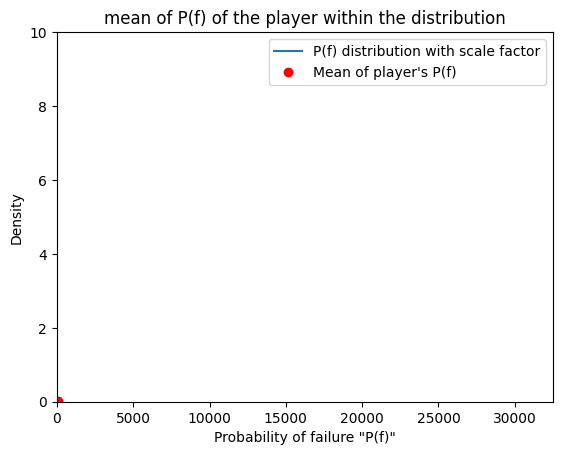

In [55]:
player_mean = df.describe().iloc[1]['p_sum_scaled']
y0 = [np.interp(player_mean,x * s_f,density(x))]
x0 = [player_mean]
p_sum = get_metric_value(week1,s_f)['p_sum_scaled'][0]
plt.title('mean of P(f) of the player within the distribution')
plt.xlabel('Probability of failure "P(f)"')
plt.ylabel('Density')
plt.plot(x * s_f, density(x))
plt.plot(x0,y0,'ro')
plt.legend(['P(f) distribution with scale factor',"Mean of player's P(f)"])
plt.axis([0, pro_df.quantile(q=q).p_sum * s_f, 0, 10])
plt.show()

In [56]:
bp = plt.boxplot(aux_s['p_sum'])

NameError: name 'aux_s' is not defined

In [ ]:
bp.keys()

In [ ]:
bp['medians'][0].get_ydata()

In [ ]:
bp['caps'][0].get_ydata()

In [ ]:
bp['caps'][1].get_ydata()

In [ ]:
testt = aux_s[aux_s['p_sum'] <= 0.61]

In [ ]:
density = stats.gaussian_kde(testt['p_sum'])
a = testt['p_sum'].tolist()
bins = np.linspace(0, 1, 400)
n, x = np.histogram(np.array(a), bins,density=True)

In [ ]:
player_mean = df.describe().iloc[1]['p_sum_scaled']
y0 = [np.interp(player_mean,x * s_f,density(x))]
x0 = [player_mean]
p_sum = get_metric_value(week1,s_f)['p_sum_scaled'][0]
plt.title('mean of P(f) of the player within the distribution')
plt.xlabel('Probability of failure "P(f)"')
plt.ylabel('Density')
plt.plot(x * s_f, density(x))
plt.plot(x0,y0,'ro')
plt.legend(['P(f) distribution with scale factor',"Mean of player's P(f)"])
plt.axis([0, pro_df.quantile(q=q).p_sum * s_f, 0, 10])
plt.show()

In [ ]:
bpt = plt.boxplot(testt['p_sum'])